# Predict Future Sales - Features, XGBoost

In [1]:
## Load library 
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from datetime import datetime, timedelta
from category_encoders import TargetEncoder 
import xgboost as xgb
import catboost as catb
from itertools import product
from sklearn.metrics import mean_squared_error
from xgboost import plot_importance

np.random.seed(123)

# Load data
sales_train = pd.read_csv('data/sales_train.csv')
test = pd.read_csv('data/test.csv')
items = pd.read_csv('data/items.csv')
item_cat = pd.read_csv('data/item_categories.csv')
shops = pd.read_csv('data/shops.csv')

## Load translated data
shops_trans = pd.read_csv('data/shops-translated.csv')
items_trans = pd.read_csv('data/items-translated.csv')
item_cat_trans = pd.read_csv('data/item_categories-translated.csv')

In [2]:
## Function to downcast data

def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
                
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
                
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    
    return df  

## Remove Outliers
Remove some outliers from the dataset
* `item_price` > 300,000
* `item_cnt_day` > 1,000
* `item_price` is negative
* Set `item_cnt_day` to 0 if negative

In [3]:
sales_train = sales_train[(sales_train.item_price < 300000) & (sales_train.item_cnt_day < 1000)]
sales_train = sales_train[sales_train.item_price > 0].reset_index(drop=True)
sales_train.loc[sales_train.item_cnt_day < 1, 'item_cnt_day'] = 0

## Main Data Creation

Create matrix with all combinations of month-shop-item. This creates a grid of all possible shop-item combinations for each month, even if they were not sold during that month. 

In [4]:
%%time

grid = []
index_cols = ['date_block_num', 'shop_id', 'item_id']
for i in sales_train['date_block_num'].unique():
    sales_temp = sales_train[sales_train.date_block_num == i]
    grid.append(np.array(list(product([i], sales_temp.shop_id.unique(), sales_temp.item_id.unique() )), dtype=np.int16))
    
grid = pd.DataFrame(np.vstack(grid), columns=index_cols)
grid.sort_values(index_cols, inplace=True)

Wall time: 8.82 s


In [5]:
grid.head(10)

,date_block_num,shop_id,item_id
139255,0,0,19
141495,0,0,27
144968,0,0,28
142661,0,0,29
138947,0,0,32
138948,0,0,33
138949,0,0,34
139247,0,0,35
142672,0,0,40
142065,0,0,41


Add item revenue variable to data. Aggregate `sales_train` to monthly.

In [6]:
%%time 

# Item revenue
sales_train['item_rev'] = sales_train['item_cnt_day'] * sales_train['item_price']

aggregate = sales_train.groupby(['date_block_num', 'shop_id', 'item_id'])\
.agg({'item_cnt_day':'sum'})\
.reset_index()\
.rename(columns = {'item_cnt_day':'item_cnt_month'})

Wall time: 661 ms


In [7]:
aggregate.isna().sum()

date_block_num    0
shop_id           0
item_id           0
item_cnt_month    0
dtype: int64

Merge aggregate data with grid of all month-shop-item combinations. For those shop-item combinations that were not sold during a month, `item_cnt_month` is 0. 

In [8]:
%%time

grid = pd.merge(grid, aggregate, on=index_cols, how='left')
grid['item_cnt_month'] = (grid['item_cnt_month'].fillna(0).clip(0,20))
# grid['item_price'] = (grid['item_price'].fillna(0))
# grid['item_rev'] = (grid['item_rev'].fillna(0))

grid = downcast(grid)

Wall time: 3.26 s


In [9]:
grid.head(10)

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,0.0
1,0,0,27,0.0
2,0,0,28,0.0
3,0,0,29,0.0
4,0,0,32,6.0
5,0,0,33,3.0
6,0,0,34,0.0
7,0,0,35,1.0
8,0,0,40,0.0
9,0,0,41,0.0


In [10]:
grid.isna().sum()

date_block_num    0
shop_id           0
item_id           0
item_cnt_month    0
dtype: int64

Create test dataset with `date_block_num`=34 and concatenate with train dataset. Fill NA values from test data with zeros. This gives us the entire dataset to train the model on for all month-sho-item combinations. 

In [11]:
%%time

test['date_block_num'] = 34

grid = pd.concat([grid, test.drop(['ID'], axis=1)], ignore_index=True, sort=False, keys=index_cols)
grid.fillna(0, inplace=True)

Wall time: 254 ms


In [12]:
grid.head(10)

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,0.0
1,0,0,27,0.0
2,0,0,28,0.0
3,0,0,29,0.0
4,0,0,32,6.0
5,0,0,33,3.0
6,0,0,34,0.0
7,0,0,35,1.0
8,0,0,40,0.0
9,0,0,41,0.0


In [13]:
grid.isna().sum()

date_block_num    0
shop_id           0
item_id           0
item_cnt_month    0
dtype: int64

In [14]:
grid = downcast(grid)

print(grid.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11128004 entries, 0 to 11128003
Data columns (total 4 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date_block_num  int8   
 1   shop_id         int8   
 2   item_id         int16  
 3   item_cnt_month  float16
dtypes: float16(1), int16(1), int8(2)
memory usage: 63.7 MB
None


Merge with supplemental information on shop names, item names and item category id. Use translated data for the names. 

In [15]:
%%time

grid = grid.merge(items, on='item_id')
grid = grid.merge(items_trans, on='item_id')
grid = grid.merge(item_cat_trans, on='item_category_id')
grid = grid.merge(shops_trans, on='shop_id')

grid = downcast(grid)

Wall time: 10.8 s


In [16]:
grid.head(10)

,date_block_num,shop_id,item_id,item_cnt_month,item_name,item_category_id,item_name_translated,item_category_name_translated,shop_name_translated
0,0,0,19,0.0,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,/ GOLDEN COLLECTION m / f-72,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs"
1,0,0,32,6.0,1+1,40,1+1,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs"
2,1,0,32,10.0,1+1,40,1+1,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs"
3,0,0,34,0.0,10 000 ЛЕТ ДО НАШЕЙ ЭРЫ WB (регион),40,10 000 YEARS OLDER OUR WB (region),Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs"
4,1,0,34,0.0,10 000 ЛЕТ ДО НАШЕЙ ЭРЫ WB (регион),40,10 000 YEARS OLDER OUR WB (region),Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs"
5,0,0,35,1.0,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs"
6,1,0,35,14.0,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs"
7,0,0,43,1.0,100 МИЛЛИОНОВ ЕВРО,40,100 MILLION EURO,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs"
8,0,0,63,0.0,101 ДАЛМАТИНЕЦ wd,40,101 DALMATINE wd,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs"
9,1,0,63,0.0,101 ДАЛМАТИНЕЦ wd,40,101 DALMATINE wd,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs"


In [17]:
grid.isna().sum()

date_block_num                   0
shop_id                          0
item_id                          0
item_cnt_month                   0
item_name                        0
item_category_id                 0
item_name_translated             0
item_category_name_translated    0
shop_name_translated             0
dtype: int64

In [18]:
print(grid.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 9 columns):
 #   Column                         Dtype   
---  ------                         -----   
 0   date_block_num                 int8    
 1   shop_id                        int8    
 2   item_id                        int16   
 3   item_cnt_month                 float16 
 4   item_name                      category
 5   item_category_id               int8    
 6   item_name_translated           category
 7   item_category_name_translated  category
 8   shop_name_translated           category
dtypes: category(4), float16(1), int16(1), int8(3)
memory usage: 224.5 MB
None


## Features

### Target variable lags
Lags of `item_cnt_month` at the shop-item level. 

In [19]:
## Function to create lags
def create_lags(df, lags, col):
    temp = df[['date_block_num', 'shop_id', 'item_id', col]]
    for i in lags:
        shifted = temp.copy()
        shifted.columns = ['date_block_num', 'shop_id', 'item_id', col+"_"+str(i)]
        shifted['date_block_num'] += i
        df = df.merge(shifted, on=['date_block_num', 'shop_id', 'item_id'], how='left')
        
        df = downcast(df)
        
    return df

In [20]:
%%time

grid = create_lags(grid, [1,2,3], 'item_cnt_month')

Wall time: 17.8 s


In [21]:
grid.head(10)

,date_block_num,shop_id,item_id,item_cnt_month,item_name,item_category_id,item_name_translated,item_category_name_translated,shop_name_translated,item_cnt_month_1,item_cnt_month_2,item_cnt_month_3
0,0,0,19,0.0,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,/ GOLDEN COLLECTION m / f-72,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,NaN,NaN
1,0,0,32,6.0,1+1,40,1+1,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,NaN,NaN
2,1,0,32,10.0,1+1,40,1+1,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",6.0,NaN,NaN
3,0,0,34,0.0,10 000 ЛЕТ ДО НАШЕЙ ЭРЫ WB (регион),40,10 000 YEARS OLDER OUR WB (region),Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,NaN,NaN
4,1,0,34,0.0,10 000 ЛЕТ ДО НАШЕЙ ЭРЫ WB (регион),40,10 000 YEARS OLDER OUR WB (region),Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",0.0,NaN,NaN
5,0,0,35,1.0,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,NaN,NaN
6,1,0,35,14.0,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",1.0,NaN,NaN
7,0,0,43,1.0,100 МИЛЛИОНОВ ЕВРО,40,100 MILLION EURO,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,NaN,NaN
8,0,0,63,0.0,101 ДАЛМАТИНЕЦ wd,40,101 DALMATINE wd,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,NaN,NaN
9,1,0,63,0.0,101 ДАЛМАТИНЕЦ wd,40,101 DALMATINE wd,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",0.0,NaN,NaN


### Item Price Lags

In [ ]:
# %%time

# grid = create_lags(grid, [1,2,3,6,12], 'item_price')

### Item Revenue lags

In [ ]:
# %%time 

# grid = create_lags(grid, [1,2,3,6,12], 'item_rev')

In [ ]:
# grid.head(10)

### New Categorical Features

Create 3 new categorical variables: `city`, `item_type` and `item_subtype`. Label encode these variables. 

In [22]:
%%time

# Create new categorical variables
grid['city'] = grid['shop_name_translated'].str.split(expand=True)[0]
grid['item_type'] = grid['item_category_name_translated'].str.split(pat='-', expand=True)[0]
grid['item_subtype'] = grid['item_category_name_translated'].str.split(pat='-', expand=True)[1]

grid = downcast(grid)

# Label encode new cat variables 
labelcols = ['city', 'item_type', 'item_subtype']
for col in labelcols:
    grid[f'{col}_id'] = grid[col].cat.codes.astype('int16')
    grid[f'{col}_id'] -= grid[f'{col}_id'].min()

Wall time: 28.1 s


In [23]:
grid.head(10)

,date_block_num,shop_id,item_id,item_cnt_month,item_name,item_category_id,item_name_translated,item_category_name_translated,shop_name_translated,item_cnt_month_1,item_cnt_month_2,item_cnt_month_3,city,item_type,item_subtype,city_id,item_type_id,item_subtype_id
0,0,0,19,0.0,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,/ GOLDEN COLLECTION m / f-72,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,NaN,NaN,Yakutsk,Cinema,DVD,30,3,22
1,0,0,32,6.0,1+1,40,1+1,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,NaN,NaN,Yakutsk,Cinema,DVD,30,3,22
2,1,0,32,10.0,1+1,40,1+1,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",6.0,NaN,NaN,Yakutsk,Cinema,DVD,30,3,22
3,0,0,34,0.0,10 000 ЛЕТ ДО НАШЕЙ ЭРЫ WB (регион),40,10 000 YEARS OLDER OUR WB (region),Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,NaN,NaN,Yakutsk,Cinema,DVD,30,3,22
4,1,0,34,0.0,10 000 ЛЕТ ДО НАШЕЙ ЭРЫ WB (регион),40,10 000 YEARS OLDER OUR WB (region),Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",0.0,NaN,NaN,Yakutsk,Cinema,DVD,30,3,22
5,0,0,35,1.0,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,NaN,NaN,Yakutsk,Cinema,DVD,30,3,22
6,1,0,35,14.0,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",1.0,NaN,NaN,Yakutsk,Cinema,DVD,30,3,22
7,0,0,43,1.0,100 МИЛЛИОНОВ ЕВРО,40,100 MILLION EURO,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,NaN,NaN,Yakutsk,Cinema,DVD,30,3,22
8,0,0,63,0.0,101 ДАЛМАТИНЕЦ wd,40,101 DALMATINE wd,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,NaN,NaN,Yakutsk,Cinema,DVD,30,3,22
9,1,0,63,0.0,101 ДАЛМАТИНЕЦ wd,40,101 DALMATINE wd,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",0.0,NaN,NaN,Yakutsk,Cinema,DVD,30,3,22


### Mean Encoding Categorical Features
Use `item_cnt_month`, the target variable to mean encode. Also known as target encoding (?).

In [42]:
## Function to mean encode
# Take as arguments: data, cols to group by, target variable to calculate mean, new column name

def create_means(df1, df2, gcols, tcol, newcol):
    group = df1.groupby(gcols)\
    .agg({tcol:'mean'})\
    .reset_index()\
    .rename(columns = {tcol:newcol})
    
    df2 = df2.merge(group, on=gcols, how='left')
    df2 = downcast(df2)
    
    return df2

#### 1. Monthly sales
Average `item_cnt_month` from previous month. 

In [26]:
%%time 

grid = create_means(grid, grid, ['date_block_num'], 'item_cnt_month', 'avg_sales')
grid = create_lags(grid, [1], 'avg_sales')
grid.drop(['avg_sales'], axis=1, inplace=True)

Wall time: 11.8 s


In [27]:
grid.head(10)

,date_block_num,shop_id,item_id,item_cnt_month,item_name,item_category_id,item_name_translated,item_category_name_translated,shop_name_translated,item_cnt_month_1,item_cnt_month_2,item_cnt_month_3,city,item_type,item_subtype,city_id,item_type_id,item_subtype_id,avg_sales_1
0,0,0,19,0.0,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,/ GOLDEN COLLECTION m / f-72,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,NaN,NaN,Yakutsk,Cinema,DVD,30,3,22,NaN
1,0,0,32,6.0,1+1,40,1+1,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,NaN,NaN,Yakutsk,Cinema,DVD,30,3,22,NaN
2,1,0,32,10.0,1+1,40,1+1,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",6.0,NaN,NaN,Yakutsk,Cinema,DVD,30,3,22,0.3479
3,0,0,34,0.0,10 000 ЛЕТ ДО НАШЕЙ ЭРЫ WB (регион),40,10 000 YEARS OLDER OUR WB (region),Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,NaN,NaN,Yakutsk,Cinema,DVD,30,3,22,NaN
4,1,0,34,0.0,10 000 ЛЕТ ДО НАШЕЙ ЭРЫ WB (регион),40,10 000 YEARS OLDER OUR WB (region),Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",0.0,NaN,NaN,Yakutsk,Cinema,DVD,30,3,22,0.3479
5,0,0,35,1.0,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,NaN,NaN,Yakutsk,Cinema,DVD,30,3,22,NaN
6,1,0,35,14.0,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",1.0,NaN,NaN,Yakutsk,Cinema,DVD,30,3,22,0.3479
7,0,0,43,1.0,100 МИЛЛИОНОВ ЕВРО,40,100 MILLION EURO,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,NaN,NaN,Yakutsk,Cinema,DVD,30,3,22,NaN
8,0,0,63,0.0,101 ДАЛМАТИНЕЦ wd,40,101 DALMATINE wd,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,NaN,NaN,Yakutsk,Cinema,DVD,30,3,22,NaN
9,1,0,63,0.0,101 ДАЛМАТИНЕЦ wd,40,101 DALMATINE wd,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",0.0,NaN,NaN,Yakutsk,Cinema,DVD,30,3,22,0.3479


#### 2. Average monthly sales by categories
Average `item_cnt_month` from previous months, grouped by 
1. shop
2. item
3. item category
4. city 
5. item type
6. item subtype

In [28]:
%%time 

cat_feats = ['shop', 'item', 'item_category', 'city', 'item_type', 'item_subtype']

for cat in cat_feats:
    grid = create_means(grid, grid, ['date_block_num', cat+'_id'], 'item_cnt_month', 'avg_'+cat+'_sales')

Wall time: 29.2 s


In [31]:
%%time

grid = create_lags(grid, [1,2,3], 'avg_shop_sales')
grid = create_lags(grid, [1,2,3], 'avg_item_sales')
grid = create_lags(grid, [1], 'avg_item_category_sales')
grid = create_lags(grid, [1], 'avg_city_sales')
grid = create_lags(grid, [1], 'avg_item_type_sales')
grid = create_lags(grid, [1], 'avg_item_subtype_sales')

Wall time: 1min 31s


In [33]:
grid.drop(['avg_shop_sales', 'avg_item_sales', 'avg_item_category_sales', 'avg_city_sales', 'avg_item_type_sales', 'avg_item_subtype_sales'], axis=1, inplace=True)

In [34]:
grid.head(10)

,date_block_num,shop_id,item_id,item_cnt_month,item_name,item_category_id,item_name_translated,item_category_name_translated,shop_name_translated,item_cnt_month_1,...,avg_shop_sales_1,avg_shop_sales_2,avg_shop_sales_3,avg_item_sales_1,avg_item_sales_2,avg_item_sales_3,avg_item_category_sales_1,avg_city_sales_1,avg_item_type_sales_1,avg_item_subtype_sales_1
0,0,0,19,0.0,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,/ GOLDEN COLLECTION m / f-72,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,32,6.0,1+1,40,1+1,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0,32,10.0,1+1,40,1+1,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",6.0,...,0.666992,NaN,NaN,5.378906,NaN,NaN,0.294189,0.51416,0.272461,0.294189
3,0,0,34,0.0,10 000 ЛЕТ ДО НАШЕЙ ЭРЫ WB (регион),40,10 000 YEARS OLDER OUR WB (region),Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0,34,0.0,10 000 ЛЕТ ДО НАШЕЙ ЭРЫ WB (регион),40,10 000 YEARS OLDER OUR WB (region),Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",0.0,...,0.666992,NaN,NaN,0.199951,NaN,NaN,0.294189,0.51416,0.272461,0.294189
5,0,0,35,1.0,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1,0,35,14.0,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",1.0,...,0.666992,NaN,NaN,1.733398,NaN,NaN,0.294189,0.51416,0.272461,0.294189
7,0,0,43,1.0,100 МИЛЛИОНОВ ЕВРО,40,100 MILLION EURO,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0,0,63,0.0,101 ДАЛМАТИНЕЦ wd,40,101 DALMATINE wd,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1,0,63,0.0,101 ДАЛМАТИНЕЦ wd,40,101 DALMATINE wd,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",0.0,...,0.666992,NaN,NaN,0.088867,NaN,NaN,0.294189,0.51416,0.272461,0.294189


#### 3. Average monthly sales by 2 categories
Average `item_cnt_month` from previous month, grouped by
1. shop-item category
2. shop-item type
3. shop-item subtype
4. city-item

In [35]:
%%time

grid = create_means(grid, grid, ['date_block_num', 'shop_id', 'item_category_id'], 'item_cnt_month', 'avg_shop_cat_sales')
grid = create_means(grid, grid, ['date_block_num', 'shop_id', 'item_type_id'], 'item_cnt_month', 'avg_shop_type_sales')
grid = create_means(grid, grid, ['date_block_num', 'shop_id', 'item_subtype_id'], 'item_cnt_month', 'avg_shop_subtype_sales')
grid = create_means(grid, grid, ['date_block_num', 'item_id', 'city_id'], 'item_cnt_month', 'avg_item_city_sales')

Wall time: 34.2 s


In [36]:
%%time

grid = create_lags(grid, [1], 'avg_shop_cat_sales')
grid = create_lags(grid, [1], 'avg_shop_type_sales')
grid = create_lags(grid, [1], 'avg_shop_subtype_sales')
grid = create_lags(grid, [1], 'avg_item_city_sales')

Wall time: 44.1 s


In [37]:
grid.drop(['avg_shop_cat_sales', 'avg_shop_type_sales', 'avg_shop_subtype_sales', 'avg_item_city_sales'], axis=1, inplace=True)

In [38]:
grid.head(10)

,date_block_num,shop_id,item_id,item_cnt_month,item_name,item_category_id,item_name_translated,item_category_name_translated,shop_name_translated,item_cnt_month_1,...,avg_item_sales_2,avg_item_sales_3,avg_item_category_sales_1,avg_city_sales_1,avg_item_type_sales_1,avg_item_subtype_sales_1,avg_shop_cat_sales_1,avg_shop_type_sales_1,avg_shop_subtype_sales_1,avg_item_city_sales_1
0,0,0,19,0.0,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,/ GOLDEN COLLECTION m / f-72,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,32,6.0,1+1,40,1+1,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0,32,10.0,1+1,40,1+1,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",6.0,...,NaN,NaN,0.294189,0.51416,0.272461,0.294189,0.739746,0.657715,0.739746,6.5
3,0,0,34,0.0,10 000 ЛЕТ ДО НАШЕЙ ЭРЫ WB (регион),40,10 000 YEARS OLDER OUR WB (region),Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0,34,0.0,10 000 ЛЕТ ДО НАШЕЙ ЭРЫ WB (регион),40,10 000 YEARS OLDER OUR WB (region),Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",0.0,...,NaN,NaN,0.294189,0.51416,0.272461,0.294189,0.739746,0.657715,0.739746,0.0
5,0,0,35,1.0,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1,0,35,14.0,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",1.0,...,NaN,NaN,0.294189,0.51416,0.272461,0.294189,0.739746,0.657715,0.739746,0.5
7,0,0,43,1.0,100 МИЛЛИОНОВ ЕВРО,40,100 MILLION EURO,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0,0,63,0.0,101 ДАЛМАТИНЕЦ wd,40,101 DALMATINE wd,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1,0,63,0.0,101 ДАЛМАТИНЕЦ wd,40,101 DALMATINE wd,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",0.0,...,NaN,NaN,0.294189,0.51416,0.272461,0.294189,0.739746,0.657715,0.739746,0.0


### Price Trends

#### 1. Last month item price trend
A month's average item price relative to average item price, for each item.

In [46]:
%%time

# Create mean price by item
grid = create_means(sales_train, grid, ['item_id'], 'item_price', 'avg_item_price')

# Create monthly mean price by item
grid = create_means(sales_train, grid, ['date_block_num', 'item_id'], 'item_price', 'avg_item_price_month')

# Price deviation 
grid['delta_price_item'] = (grid['avg_item_price_month'] - grid['avg_item_price']) / grid['avg_item_price']

# 1 month lag of price deviation
grid = create_lags(grid, [1], 'delta_price_item')

Wall time: 16.6 s


In [48]:
grid.drop(['avg_item_price', 'avg_item_price_month'], axis=1, inplace=True)

In [49]:
grid.head(10)

,date_block_num,shop_id,item_id,item_cnt_month,item_name,item_category_id,item_name_translated,item_category_name_translated,shop_name_translated,item_cnt_month_1,...,avg_item_category_sales_1,avg_city_sales_1,avg_item_type_sales_1,avg_item_subtype_sales_1,avg_shop_cat_sales_1,avg_shop_type_sales_1,avg_shop_subtype_sales_1,avg_item_city_sales_1,delta_price_item,delta_price_item_1
0,0,0,19,0.0,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,/ GOLDEN COLLECTION m / f-72,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
1,0,0,32,6.0,1+1,40,1+1,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.354004,NaN
2,1,0,32,10.0,1+1,40,1+1,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",6.0,...,0.294189,0.51416,0.272461,0.294189,0.739746,0.657715,0.739746,6.5,0.353027,0.354004
3,0,0,34,0.0,10 000 ЛЕТ ДО НАШЕЙ ЭРЫ WB (регион),40,10 000 YEARS OLDER OUR WB (region),Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.023392,NaN
4,1,0,34,0.0,10 000 ЛЕТ ДО НАШЕЙ ЭРЫ WB (регион),40,10 000 YEARS OLDER OUR WB (region),Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",0.0,...,0.294189,0.51416,0.272461,0.294189,0.739746,0.657715,0.739746,0.0,0.032928,-0.023392
5,0,0,35,1.0,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.039917,NaN
6,1,0,35,14.0,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",1.0,...,0.294189,0.51416,0.272461,0.294189,0.739746,0.657715,0.739746,0.5,-0.021957,0.039917
7,0,0,43,1.0,100 МИЛЛИОНОВ ЕВРО,40,100 MILLION EURO,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.402100,NaN
8,0,0,63,0.0,101 ДАЛМАТИНЕЦ wd,40,101 DALMATINE wd,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.042511,NaN
9,1,0,63,0.0,101 ДАЛМАТИНЕЦ wd,40,101 DALMATINE wd,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",0.0,...,0.294189,0.51416,0.272461,0.294189,0.739746,0.657715,0.739746,0.0,0.055817,0.042511


#### 2. Last month shop price trend

In [ ]:
%%time 

# Create mean price by shop
grid = create_means(grid, ['shop_id'], 'item_price', 'avg_shop_price')

# Create monthly mean price by item
grid = create_means(grid, ['date_block_num', 'shop_id'], 'item_price', 'avg_shop_price_month')

# Price deviation 
grid['delta_price_shop'] = (grid['avg_shop_price_month'] - grid['avg_shop_price']) / grid['avg_shop_price']

# 1 month lag of price deviation
grid = create_lags(grid, [1], 'delta_price_shop')

In [ ]:
grid.head(10)

### Revenue Trends

#### 1. Last month shop revenue trend
A month's shop revenue relative to total shop revenue, by shop. 

In [51]:
%%time 

# Create monthly total shop revenue 
revtemp = sales_train.groupby(['date_block_num', 'shop_id'])\
.agg({'item_rev':'sum'})\
.reset_index()\
.rename(columns={'item_rev':'total_shop_rev'})

grid = grid.merge(revtemp, on=['date_block_num', 'shop_id'], how='left')
grid = downcast(grid)

Wall time: 6.85 s


In [53]:
%%time 

# Create mean of monthly total shop revenue by shop
grid = create_means(revtemp, grid, ['shop_id'], 'total_shop_rev', 'avg_shop_rev')

# Revenue deviation
grid['delta_rev_shop'] = (grid['total_shop_rev'] - grid['avg_shop_rev'])/ grid['avg_shop_rev']

# 1 month lag of revenue deviation
grid = create_lags(grid, [1], 'delta_rev_shop')

Wall time: 16.1 s


In [55]:
grid.drop(['total_shop_rev', 'avg_shop_rev'], axis=1, inplace=True)

In [56]:
grid.head(10)

,date_block_num,shop_id,item_id,item_cnt_month,item_name,item_category_id,item_name_translated,item_category_name_translated,shop_name_translated,item_cnt_month_1,...,avg_item_type_sales_1,avg_item_subtype_sales_1,avg_shop_cat_sales_1,avg_shop_type_sales_1,avg_shop_subtype_sales_1,avg_item_city_sales_1,delta_price_item,delta_price_item_1,delta_rev_shop,delta_rev_shop_1
0,0,0,19,0.0,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,/ GOLDEN COLLECTION m / f-72,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,-0.10614,NaN
1,0,0,32,6.0,1+1,40,1+1,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.354004,NaN,-0.10614,NaN
2,1,0,32,10.0,1+1,40,1+1,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",6.0,...,0.272461,0.294189,0.739746,0.657715,0.739746,6.5,0.353027,0.354004,0.10614,-0.10614
3,0,0,34,0.0,10 000 ЛЕТ ДО НАШЕЙ ЭРЫ WB (регион),40,10 000 YEARS OLDER OUR WB (region),Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.023392,NaN,-0.10614,NaN
4,1,0,34,0.0,10 000 ЛЕТ ДО НАШЕЙ ЭРЫ WB (регион),40,10 000 YEARS OLDER OUR WB (region),Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",0.0,...,0.272461,0.294189,0.739746,0.657715,0.739746,0.0,0.032928,-0.023392,0.10614,-0.10614
5,0,0,35,1.0,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.039917,NaN,-0.10614,NaN
6,1,0,35,14.0,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",1.0,...,0.272461,0.294189,0.739746,0.657715,0.739746,0.5,-0.021957,0.039917,0.10614,-0.10614
7,0,0,43,1.0,100 МИЛЛИОНОВ ЕВРО,40,100 MILLION EURO,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.402100,NaN,-0.10614,NaN
8,0,0,63,0.0,101 ДАЛМАТИНЕЦ wd,40,101 DALMATINE wd,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.042511,NaN,-0.10614,NaN
9,1,0,63,0.0,101 ДАЛМАТИНЕЦ wd,40,101 DALMATINE wd,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",0.0,...,0.272461,0.294189,0.739746,0.657715,0.739746,0.0,0.055817,0.042511,0.10614,-0.10614


### Other Special Features

#### Month variable

In [57]:
# Add a month variable
grid['month'] = (grid['date_block_num'] % 12) 

print(grid['month'].unique())

[ 0  1  2  3  4  5  6  7  8  9 10 11]


#### # days in month 

In [58]:
# Add number of days in the month
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
grid['days'] = grid['month'].map(days)

print(grid['days'].unique())

[31 28 30]


#### Months since first sale for each shop-item combination and item only

In [59]:
%%time

grid['shop_item_first_sale'] = grid['date_block_num'] - grid.groupby(['shop_id', 'item_id'])['date_block_num'].transform('min')

grid['item_first_sale'] = grid['date_block_num'] - grid.groupby(['item_id'])['date_block_num'].transform('min')

Wall time: 1.4 s


In [60]:
grid = downcast(grid)

grid.head(10)

,date_block_num,shop_id,item_id,item_cnt_month,item_name,item_category_id,item_name_translated,item_category_name_translated,shop_name_translated,item_cnt_month_1,...,avg_shop_subtype_sales_1,avg_item_city_sales_1,delta_price_item,delta_price_item_1,delta_rev_shop,delta_rev_shop_1,month,days,shop_item_first_sale,item_first_sale
0,0,0,19,0.0,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,/ GOLDEN COLLECTION m / f-72,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,...,NaN,NaN,0.000000,NaN,-0.10614,NaN,0,31,0,0
1,0,0,32,6.0,1+1,40,1+1,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,...,NaN,NaN,0.354004,NaN,-0.10614,NaN,0,31,0,0
2,1,0,32,10.0,1+1,40,1+1,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",6.0,...,0.739746,6.5,0.353027,0.354004,0.10614,-0.10614,1,28,1,1
3,0,0,34,0.0,10 000 ЛЕТ ДО НАШЕЙ ЭРЫ WB (регион),40,10 000 YEARS OLDER OUR WB (region),Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,...,NaN,NaN,-0.023392,NaN,-0.10614,NaN,0,31,0,0
4,1,0,34,0.0,10 000 ЛЕТ ДО НАШЕЙ ЭРЫ WB (регион),40,10 000 YEARS OLDER OUR WB (region),Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",0.0,...,0.739746,0.0,0.032928,-0.023392,0.10614,-0.10614,1,28,1,1
5,0,0,35,1.0,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,...,NaN,NaN,0.039917,NaN,-0.10614,NaN,0,31,0,0
6,1,0,35,14.0,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",1.0,...,0.739746,0.5,-0.021957,0.039917,0.10614,-0.10614,1,28,1,1
7,0,0,43,1.0,100 МИЛЛИОНОВ ЕВРО,40,100 MILLION EURO,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,...,NaN,NaN,0.402100,NaN,-0.10614,NaN,0,31,0,0
8,0,0,63,0.0,101 ДАЛМАТИНЕЦ wd,40,101 DALMATINE wd,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,...,NaN,NaN,0.042511,NaN,-0.10614,NaN,0,31,0,0
9,1,0,63,0.0,101 ДАЛМАТИНЕЦ wd,40,101 DALMATINE wd,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",0.0,...,0.739746,0.0,0.055817,0.042511,0.10614,-0.10614,1,28,1,1


### Final Data for modelling
Drop first 3 months of data since max lag value used is 3. 

In [61]:
%%time

grid = grid[grid.date_block_num > 3]

Wall time: 1.29 s


In [62]:
grid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9630539 entries, 32571 to 11128003
Data columns (total 41 columns):
 #   Column                         Dtype   
---  ------                         -----   
 0   date_block_num                 int8    
 1   shop_id                        int8    
 2   item_id                        int16   
 3   item_cnt_month                 float16 
 4   item_name                      category
 5   item_category_id               int8    
 6   item_name_translated           category
 7   item_category_name_translated  category
 8   shop_name_translated           category
 9   item_cnt_month_1               float16 
 10  item_cnt_month_2               float16 
 11  item_cnt_month_3               float16 
 12  city                           category
 13  item_type                      category
 14  item_subtype                   category
 15  city_id                        int8    
 16  item_type_id                   int8    
 17  item_subtype_id       

In [63]:
grid.head().T

,32571,32572,32573,32574,32575
date_block_num,4,5,6,7,8
shop_id,2,2,2,2,2
item_id,32,32,32,32,32
item_cnt_month,0,0,0,0,0
item_name,1+1,1+1,1+1,1+1,1+1
item_category_id,40,40,40,40,40
item_name_translated,1+1,1+1,1+1,1+1,1+1
item_category_name_translated,Cinema - DVD,Cinema - DVD,Cinema - DVD,Cinema - DVD,Cinema - DVD
shop_name_translated,"Adygea Shopping Center ""Mega""","Adygea Shopping Center ""Mega""","Adygea Shopping Center ""Mega""","Adygea Shopping Center ""Mega""","Adygea Shopping Center ""Mega"""
item_cnt_month_1,0,0,0,0,0


## Model - XGBoost

In [64]:
%%time

grid.to_csv('data/model_fit_data_8_4.csv', index=False)

Wall time: 3min 27s


In [81]:
%%time

grid = pd.read_csv('data/model_fit_data_8_4.csv')

Wall time: 27.9 s


`date_block_num` 4-32 is train set, `date_block_num`=33 is the validation set and `date_block_num`=34 is the test set. 

In [83]:
grid.columns

Index(['Unnamed: 0', 'date_block_num', 'shop_id', 'item_id', 'item_cnt_month',
       'item_name', 'item_category_id', 'item_name_translated',
       'item_category_name_translated', 'shop_name_translated',
       'item_cnt_month_1', 'item_cnt_month_2', 'item_cnt_month_3', 'city',
       'item_type', 'item_subtype', 'city_id', 'item_type_id',
       'item_subtype_id', 'avg_sales_1', 'avg_shop_sales_1',
       'avg_shop_sales_2', 'avg_shop_sales_3', 'avg_item_sales_1',
       'avg_item_sales_2', 'avg_item_sales_3', 'avg_item_category_sales_1',
       'avg_city_sales_1', 'avg_item_type_sales_1', 'avg_item_subtype_sales_1',
       'avg_shop_cat_sales_1', 'avg_shop_type_sales_1',
       'avg_shop_subtype_sales_1', 'avg_item_city_sales_1', 'delta_price_item',
       'delta_price_item_1', 'delta_rev_shop', 'delta_rev_shop_1', 'month',
       'days', 'shop_item_first_sale', 'item_first_sale'],
      dtype='object')

In [84]:
del_cols=['item_cnt_month', 'item_name', 'item_name_translated', 'item_category_name_translated', 'shop_name_translated', 
          'city', 'item_type', 'item_subtype', 'delta_rev_shop', 'delta_rev_shop_1', 'Unnamed: 0']

In [85]:
X_train = grid[grid.date_block_num < 33].drop(del_cols, axis=1)
y_train = grid[grid.date_block_num < 33]['item_cnt_month']
X_valid = grid[grid.date_block_num == 33].drop(del_cols, axis=1)
y_valid = grid[grid.date_block_num == 33]['item_cnt_month']
X_test = grid[grid.date_block_num == 34].drop(del_cols, axis=1)

In [86]:
del grid
gc.collect();

In [87]:
%%time 

model_xgb = xgb.XGBRegressor(
    max_depth=10, 
    n_estimators=1000, 
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1, 
    seed=42, 
    n_jobs=15)

model_xgb.fit(
    X_train, 
    y_train, 
    eval_metric='rmse', 
    eval_set=[(X_train, y_train), (X_valid, y_valid)], 
    verbose=True, 
    early_stopping_rounds=20)

[15:14:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:14:01] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.17431	validation_1-rmse:1.11677
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:1.12542	validation_1-rmse:1.08265
[2]	validation_0-rmse:1.07998	validation_1-rmse:1.05411
[3]	validation_0-rmse:1.04443	validation_1-rmse:1.0303
[4]	validation_0-rmse:1.0125	validation_1-rmse:1.01001
[5]	validation_0-rmse:0.984433	validation_1-rmse:0.994164
[6]	validation_0-rmse:0.959927	validation_1-rmse:0.979851
[7]	validation_0-rmse:0.9407	validation_1-rmse:0.96681
[8]	validation_0-rmse:0.92337	validation_1-rmse:0.95796
[9]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=0.5, missing=None,
             n_estimators=1000, n_jobs=15, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=42, silent=None, subsample=0.8, verbosity=1)

In [88]:
%%time

# Predict
y_train_pred_xgb = model_xgb.predict(X_train).clip(0,20)
y_valid_pred_xgb = model_xgb.predict(X_valid).clip(0,20)
y_test_xgb = model_xgb.predict(X_test).clip(0,20)

Wall time: 7.53 s


In [89]:
print('Train RMSE:', np.sqrt(mean_squared_error(y_train, y_train_pred_xgb)) )
print('Valid RMSE:', np.sqrt(mean_squared_error(y_valid, y_valid_pred_xgb)) )

Train RMSE: 0.7586025955029131
Valid RMSE: 0.9092159990333993


In [90]:
submission = pd.DataFrame({'ID':test.index, 'item_cnt_month':y_test_xgb})
submission.to_csv('xgb_submission3.csv', index=False)

In [91]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

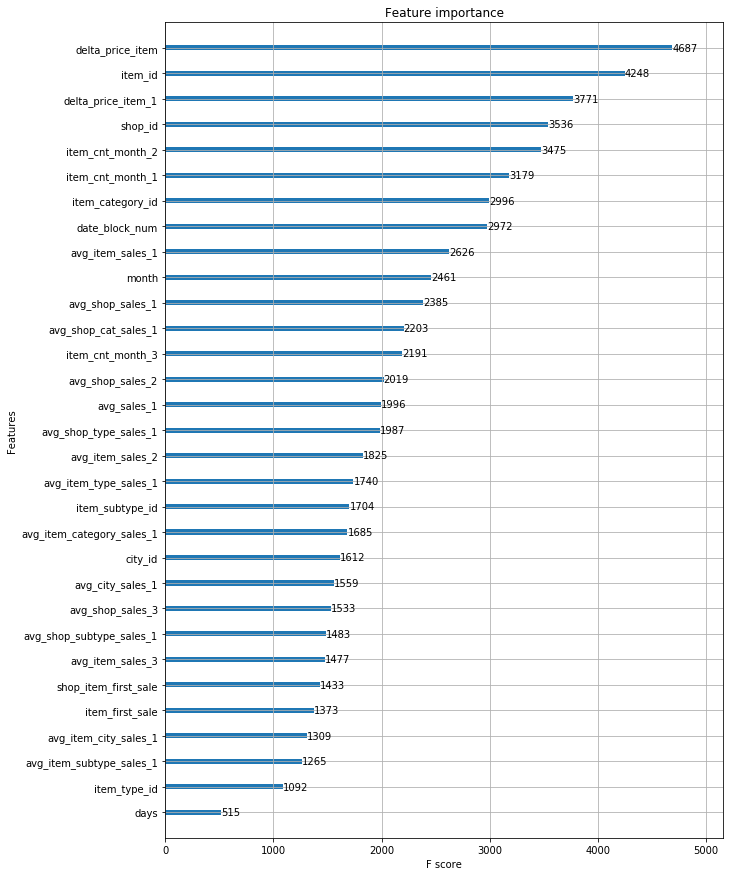

In [92]:
plot_features(model_xgb, (10,15))

In [95]:
submission.head(10)

,ID,item_cnt_month
0,0,0.164162
1,1,0.025243
2,2,0.025243
3,3,0.025243
4,4,0.025243
5,5,0.025243
6,6,0.025243
7,7,0.025243
8,8,0.094371
9,9,0.025243
